In [23]:
%plot
% define surftat toolbox dir
addpath('/Users/kanaan/SCR/Github/Tourettome/algorithms/surfstats/software/surfstat_chicago')
addpath('/Users/kanaan/SCR/Github/Tourettome/algorithms/npy_matlab')

%% Input/Output 
tourettome_dir = '/Users/kanaan/SCR/workspace/project_touretome/';
freesurfer_dir = [tourettome_dir 'freesurfer/'];
fsaverage5_dir = [freesurfer_dir 'fsaverage5/surf_fsa5/'];
results_dir    = [freesurfer_dir '/cortical_thickness/STATISTICS/'];

qsm_dir = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/dataframes/';
phenotypic     = [qsm_dir 'phenotypic/pheno_sca.csv'];

% blue cmap
ice = textread('ice.m');

# Read fs data 

In [24]:
surf_sphere = SurfStatReadSurf({[fsaverage5_dir 'lh.sphere'],[fsaverage5_dir 'rh.sphere']});
surf_curv   = SurfStatReadData({[fsaverage5_dir 'fsaverage_curv_lh.asc'],[fsaverage5_dir 'fsaverage_curv_rh.asc']});
surf_infl   = SurfStatReadSurf({[fsaverage5_dir 'lh.inflated'],[fsaverage5_dir 'rh.inflated']});
surf_white  = SurfStatReadSurf({[fsaverage5_dir 'lh.white'],[fsaverage5_dir 'rh.white']});
surf_pial   = SurfStatReadSurf({[fsaverage5_dir 'lh.pial'],[fsaverage5_dir 'rh.pial']});

surf_mid_ct.tri   = surf_white.tri;
surf_mid_ct.coord = (surf_white.coord + surf_white.coord)./2;

# read pheno data 

In [25]:
% cols = [Age 	EFC_MAG 	Gender 	Group 	QI1_MAG

phenotypic_fid  = fopen(phenotypic);
phenotypic_data = textscan(phenotypic_fid,'%s%f%f%f%f%s%f','Delimiter',',','headerLines',1,'CollectOutput',1);
fclose(phenotypic_fid);

% subject 	Age 	Group 	Sex 	Site
phenotypic_id         = phenotypic_data{1};
phenotypic_fd         = phenotypic_data{2}(:,1);
phenotypic_age        = phenotypic_data{2}(:,2);
phenotypic_efc        = phenotypic_data{2}(:,3);
phenotypic_sex        = phenotypic_data{2}(:,4);
phenotypic_group      = phenotypic_data{3};
phenotypic_qi1        = phenotypic_data{4};


In [26]:
phenotypic_id


phenotypic_id =

  43x1 cell array

    {'LZ067'}
    {'LZ068'}
    {'LZ069'}
    {'LZ047'}
    {'LZ071'}
    {'LZ075'}
    {'LZ062'}
    {'LZ045'}
    {'LZ055'}
    {'LZ051'}
    {'LZ060'}
    {'LZ050'}
    {'LZ048'}
    {'LZ063'}
    {'LZ053'}
    {'LZ041'}
    {'LZ056'}
    {'LZ070'}
    {'LZ044'}
    {'LZ073'}
    {'LZ061'}
    {'LZ003'}
    {'LZ014'}
    {'LZ002'}
    {'LZ021'}
    {'LZ006'}
    {'LZ005'}
    {'LZ032'}
    {'LZ026'}
    {'LZ008'}
    {'LZ031'}
    {'LZ013'}
    {'LZ029'}
    {'LZ035'}
    {'LZ024'}
    {'LZ023'}
    {'LZ030'}
    {'LZ037'}
    {'LZ004'}
    {'LZ039'}
    {'LZ025'}
    {'LZ034'}
    {'LZ018'}



# load SCA data 

In [59]:
sca_lh = strcat(tourettome_dir, 'derivatives/func_seed_correlation/gsr/STR3_EXEC/',  phenotypic_id, '_sca_z_fsaverage5_fwhm10_lh.mgh');
sca_rh = strcat(tourettome_dir, 'derivatives/func_seed_correlation/gsr/STR3_EXEC/',  phenotypic_id, '_sca_z_fsaverage5_fwhm10_rh.mgh');


% load all subject data into a matrix
SCA20  = zeros(length(phenotypic_id),size(surf_white.coord,2));
for i = 1:length(phenotypic_id)
    try
       lh      = SurfStatReadData1(sca_lh{i}); 
       rh      = SurfStatReadData1(sca_rh{i}); 
       SCA20(i,:)  = [lh, rh];
       %disp(ID{i}) 
    end
end


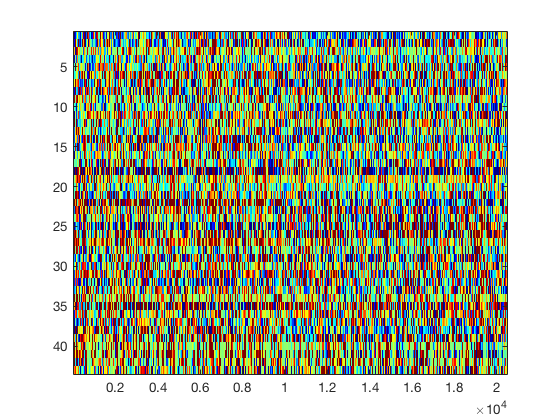

In [60]:
%  visualize data matrix (n_vertices x n_subjects)
imagesc(SCA20, [-0.2 0.2]);
colormap(jet)

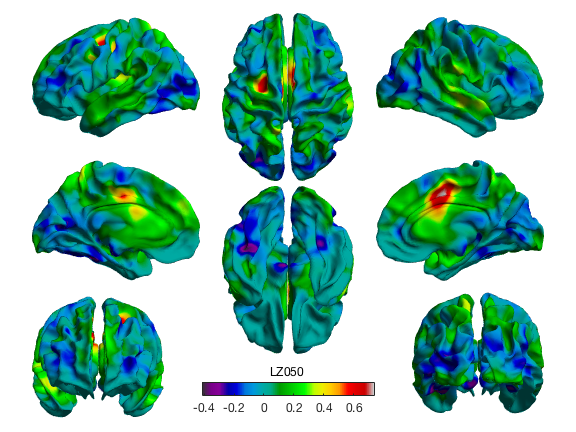

In [61]:
% visualize CT of first subject 
subject_id = 12;
SurfStatViewData(SCA20(subject_id,:), surf_white, phenotypic_id(subject_id));
%SurfStatColLim([1.5,4]);

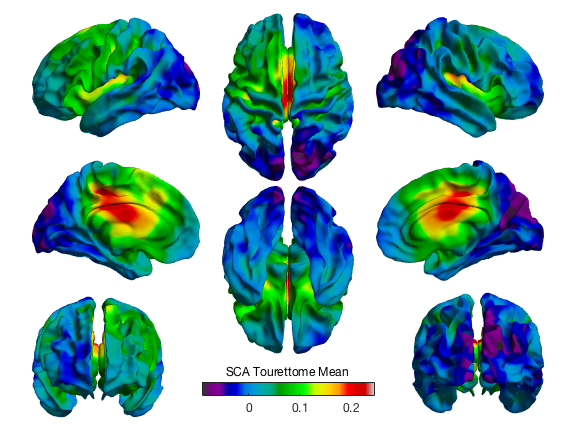

In [62]:
% visualize mean CT of tourettome subject 
SurfStatViewData(mean(SCA20,1), surf_mid_ct, 'SCA Tourettome Mean');
%SurfStatColLim([-1 1]);


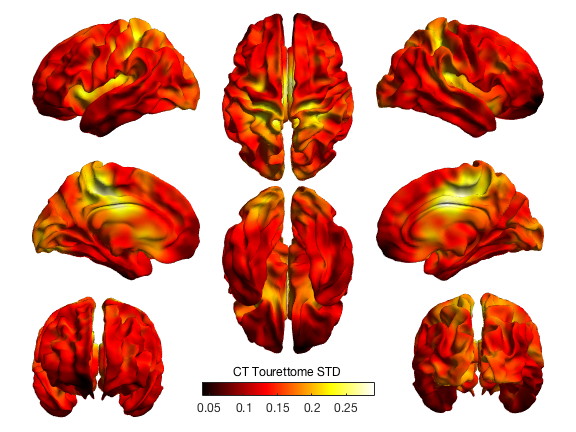

In [63]:
% this is the standard deviation across cases     
SurfStatViewData(std(SCA20,0,1),surf_mid_ct, 'CT Tourettome STD');
%SurfStatColLim([0 .5]);
colormap(hot)


In [64]:
% code variables of interest as terms 
term_age    = term(phenotypic_age);
term_group  = term(phenotypic_group);
term_sex    = term(phenotypic_sex);
term_fd     = term(phenotypic_fd);
term_efc    = term(phenotypic_efc);
term_qi1    = term(phenotypic_qi1);


% buid linear model controlled for site, group, age, sex
df_model  = 1 + term_group ;

% Estimaste model parameters
stat_model      = SurfStatLinMod(SCA20,df_model,surf_white);


% Specify model contrast
stat_model      = SurfStatT(stat_model,term_group.Contols - term_group.Patients); 

> In SurfStatT (line 44)
Concatenation including empty arrays will require all arrays to have the same number of rows in a future release.


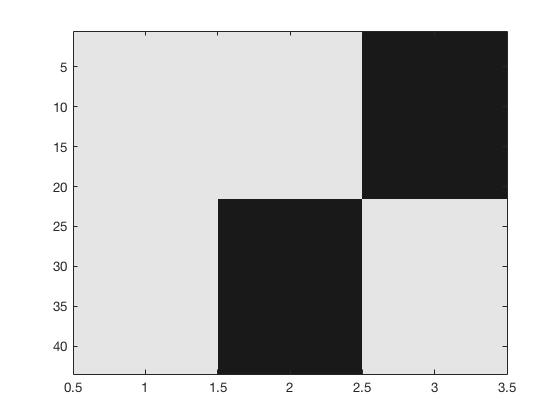

In [65]:
df_model_mat = df_model(:, :);
imagesc(df_model_mat, [0 63])
cmap = jet;
cmap(2,:) =[0.9 0.9 0.9];
cmap(1,:) =[0.1 .1 .1];
colormap(cmap)
%set(gca, 'XAxisLocation', 'top', 'XTickLabel', ...
%{'Intercept', 'Age', 'Gender-F',  'Gender-M', 'HM', 'HA', 'HB','LZ', 'PA', 'controls', 'patients'})
%xtickangle(90)


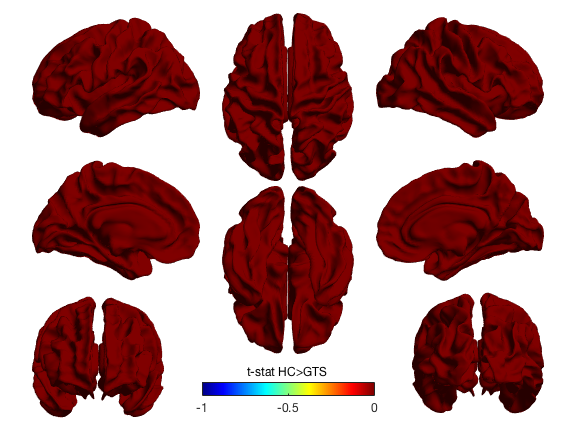

In [69]:
SurfStatViewData(stat_model.t,surf_mid_ct,'t-stat HC>GTS');
%SurfStatColLim([-4 4]) ;
colormap(jet)

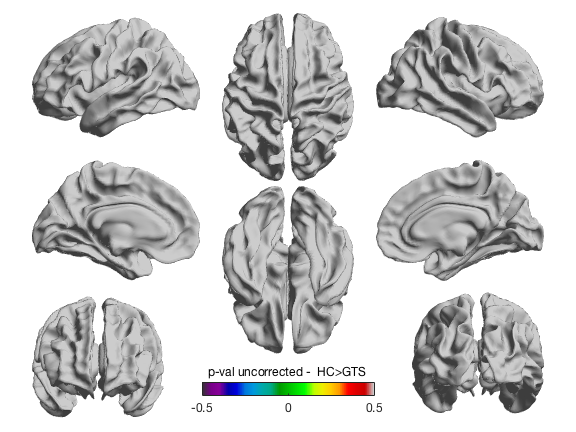

In [70]:
% alternative 1: none - we show uncorrected p-values, good for exploration
p = 1-tcdf(stat_model.t,stat_model.df); 
SurfStatViewData(p,surf_mid_ct,'p-val uncorrected -  HC>GTS');
%SurfStatColLim([0 0.05]) ;
%colormap([parula; .8 .8 .8])


In [ ]:
% alternative 1: none - we show uncorrected p-values, good for exploration
p = 1-tcdf(stat_model.t,stat_model.df); 
SurfStatViewData(p,surf_mid_ct,'p-val uncorrected -  HC>GTS');
%SurfStatColLim([0 0.05]) ;
%colormap([parula; .8 .8 .8])


In [68]:
%% generate the mask using heuristic approach 
% ------------------------
mask  = mean(SCA20,1) > 0.4;

%% clusp setting across all analyses
% ------------------------
%clusp = 0.005; 
fwe_threshold = 0.005; 

[pval, peak, clus, clusid] = SurfStatP(stat_model, mask, fwe_threshold);
pval = SurfStatP(stat_model,mask); 

effect = stat_model.t; 
SurfStatViewData(effect, surf_white, '');





Struct contents reference from a non-struct array object.

Error in SurfStatP (line 87)
        [10 peak.t' slm.t(1,:)],thresh,[10; clus.resels],[],slm.k,[],[],0);

